<a href="https://colab.research.google.com/github/sethschober/Module-4/blob/main/notebooks/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports & declarations

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split

import keras
from keras.preprocessing.image import img_to_array, load_img, array_to_img, ImageDataGenerator
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import *
import tensorflow as tf

LOCAL_PATH_MINI = '../data/raw/kaggle_mini_subsample'
LOCAL_PATH_TRAIN = '../data/raw/train'
COLAB_PATH_TRAIN = '/content/drive/MyDrive/Data Science/Colab Notebooks/Module 4 Project/data/raw/train'
COLAB_PATH_MINI = '/content/drive/MyDrive/Data Science/Colab Notebooks/Module 4 Project/data/raw/mini_subsample'

RANDOM_STATE = 2020

# Comment when running locally, uncomment for Google Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Define basic functions

In [3]:
def make_flat(x):
    s = x.shape
    dim_0 = s[0]
    dim_1 = s[1]*s[2]*s[3]
    x_flat = x.reshape(dim_0, dim_1)
    shape = (x_flat.shape[1],)
    return x_flat, shape

In [4]:
def plot_results(history, metrics=['accuracy'], val=True):
    
    for metric in metrics:
        x = range(len(history[metric]))

        plt.figure()
        plt.plot(x, history[metric], label='Train')

        if val == True:
            plt.plot(x, history['val_'+metric], label='Validation')
        plt.title(metric)
        plt.legend();

## Mini Dataset

#### Import & Clean

In [4]:
# TESTING TO GET LABEL ENCODING CORRECT

path = COLAB_PATH_MINI
data_tf = tf.keras.preprocessing.image_dataset_from_directory(path, 
                                                image_size=(32, 32),
                                                class_names=['NORMAL', 'PNEUMONIA'],
                                                seed=RANDOM_STATE)

print('CLASS NAMES:', data_tf.class_names, 'CORRESPOND TO [0,1]')
for i, item in enumerate(data_tf.as_numpy_iterator()):
    if i == 0:
        images = np.array(item[0])
        labels = np.array(item[1])
    else:
        images = np.concatenate([images, item[0]], axis=0)
        labels = np.concatenate([labels, item[1]], axis=0)
        if i % 10 == 0:
            print(int(i/(5232/BATCH_SIZE)*100), '%')

images /= 256

labels_inverted = np.array([0 if i == 1 else 1 for i in labels])
labels = np.concatenate([labels_inverted.reshape(-1,1), labels.reshape(-1,1)], axis=1)


# print('Data shape:', images.shape)
# print('Label shape:', labels.shape)

Found 200 files belonging to 2 classes.
CLASS NAMES: ['NORMAL', 'PNEUMONIA'] CORRESPOND TO [0,1]


Found 200 images belonging to 2 classes.


'Example image:'

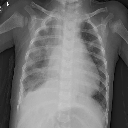

Indices: {'NORMAL': 0, 'PNEUMONIA': 1}
Dataset shape: (200, 128, 128, 3)


In [5]:
BATCH_SIZE = 250
TARGET_SIZE = [128, 128]

path = COLAB_PATH_MINI
image_generator = ImageDataGenerator().flow_from_directory(path, batch_size=BATCH_SIZE, target_size=TARGET_SIZE);
images, labels = next(image_generator)
images_scaled = images / 255

display('Example image:', array_to_img(images[0]))
print('Indices:', image_generator.class_indices)
print('Dataset shape:', images_scaled.shape)

#### Mini Dataset Model

Epoch 1/50
7/7 [==============================] - 14s 6ms/step - loss: 4.4837 - accuracy: 0.4842
Epoch 2/50
7/7 [==============================] - 0s 5ms/step - loss: 0.6978 - accuracy: 0.7057
Epoch 3/50
7/7 [==============================] - 0s 5ms/step - loss: 0.5988 - accuracy: 0.6768
Epoch 4/50
7/7 [==============================] - 0s 5ms/step - loss: 0.6409 - accuracy: 0.5909
Epoch 5/50
7/7 [==============================] - 0s 5ms/step - loss: 0.5189 - accuracy: 0.7653
Epoch 6/50
7/7 [==============================] - 0s 5ms/step - loss: 0.7121 - accuracy: 0.5821
Epoch 7/50
7/7 [==============================] - 0s 4ms/step - loss: 0.5515 - accuracy: 0.7805
Epoch 8/50
7/7 [==============================] - 0s 5ms/step - loss: 0.5052 - accuracy: 0.7186
Epoch 9/50
7/7 [==============================] - 0s 5ms/step - loss: 0.8192 - accuracy: 0.7773
Epoch 10/50
7/7 [==============================] - 0s 6ms/step - loss: 0.7266 - accuracy: 0.5909
Epoch 11/50
7/7 [=====================

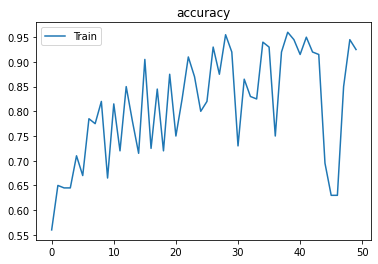

In [6]:
x, shape = make_flat(images_scaled)

model = Sequential()
model.add(Dense(32, activation='relu', input_shape = shape))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x=x, y=labels, epochs=50)

plot_results(history.history, val=False)

model.summary()

## Full Dataset

### Import and clean

In [5]:
path = COLAB_PATH_TRAIN
BATCH_SIZE = 32
data_tf = tf.keras.preprocessing.image_dataset_from_directory(path, 
                                                image_size=(128, 128), # Can work up to 256
                                                batch_size=BATCH_SIZE,
                                                class_names=['NORMAL', 'PNEUMONIA'],                                                
                                                seed=RANDOM_STATE)

print('CLASS NAMES:', data_tf.class_names, 'CORRESPOND TO [0,1]')

for i, item in enumerate(data_tf.as_numpy_iterator()):
    if i == 0:
        images = np.array(item[0])
        labels = np.array(item[1])
    else:
        images = np.concatenate([images, item[0]], axis=0)
        labels = np.concatenate([labels, item[1]], axis=0)
        if i % 10 == 0:
            print(int(i/(5232/BATCH_SIZE)*100), '%')

images /= 256

labels_inverted = np.array([0 if i == 1 else 1 for i in labels])
labels = np.concatenate([labels_inverted.reshape(-1,1), labels.reshape(-1,1)], axis=1)

#data_tf = None # clear RAM
print('Data shape:', images.shape)
print('Label shape:', labels.shape)

Found 5232 files belonging to 2 classes.
CLASS NAMES: ['NORMAL', 'PNEUMONIA'] CORRESPOND TO [0,1]
6 %
12 %
18 %
24 %
30 %
36 %
42 %
48 %
55 %
61 %
67 %
73 %
79 %
85 %
91 %
97 %
Data shape: (5232, 128, 128, 3)
Label shape: (5232, 2)


In [8]:
# BATCH_SIZE_TRAIN = 1341+3875
# TARGET_SIZE = [256, 256]

# path = COLAB_PATH_TRAIN

# t0 = time.time()
# generator = ImageDataGenerator().flow_from_directory(path,
#                                                      #batch_size=BATCH_SIZE_TRAIN,
#                                                      target_size=TARGET_SIZE)

# images, labels = next(generator)
# images = images / 256
# t1 = time.time()

# print('Runtime:', t1-t0)
# print(images.shape, labels.shape)

CHANGE TERMINOLOGY TO FIRST SIMPLE MODEL, INSTEAD OF BASELINE. BASELINE IS RANDOM GUESS

Notes:
- Remove MSE

### Baseline Model

Epoch 1/100
123/123 [==============================] - 2s 8ms/step - loss: 0.8778 - accuracy: 0.7026 - mse: 0.2035 - val_loss: 0.3606 - val_accuracy: 0.7416 - val_mse: 0.1150
Epoch 2/100
123/123 [==============================] - 1s 7ms/step - loss: 0.4163 - accuracy: 0.7728 - mse: 0.1372 - val_loss: 0.3700 - val_accuracy: 0.8853 - val_mse: 0.1169
Epoch 3/100
123/123 [==============================] - 1s 7ms/step - loss: 0.3211 - accuracy: 0.8742 - mse: 0.1046 - val_loss: 0.2602 - val_accuracy: 0.9304 - val_mse: 0.0830
Epoch 4/100
123/123 [==============================] - 1s 8ms/step - loss: 0.2811 - accuracy: 0.9059 - mse: 0.0901 - val_loss: 0.3197 - val_accuracy: 0.8754 - val_mse: 0.1025
Epoch 5/100
123/123 [==============================] - 1s 8ms/step - loss: 0.2698 - accuracy: 0.9123 - mse: 0.0850 - val_loss: 0.2158 - val_accuracy: 0.9442 - val_mse: 0.0655
Epoch 6/100
123/123 [==============================] - 1s 8ms/step - loss: 0.2333 - accuracy: 0.9294 - mse: 0.0718 - val_loss

None

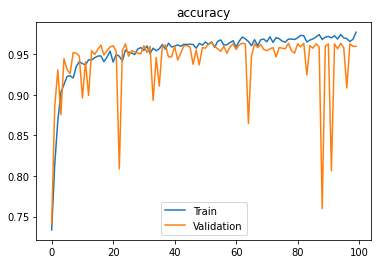

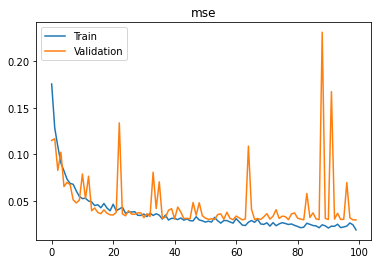

In [19]:
x, shape = make_flat(images)

model = Sequential()
model.add(Dense(10, activation='relu', input_shape = shape))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='SGD', metrics=['accuracy', 'mse'], loss='categorical_crossentropy')


history = model.fit(x=x, y=labels, 
                    epochs=100, 
                    verbose=1,
                    validation_split=0.25)

display(model.summary())


plot_results(history.history, ['accuracy', 'mse'])

### Define Callbacks

In [6]:
callbacks = [EarlyStopping(monitor='val_loss', patience=25),
             ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)]


### Entire train dataset, validation split

##### Create and fit model

In [12]:
x, shape = make_flat(images)

model = Sequential()
model.add(Dense(32, activation='relu', input_shape = shape))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy', 'mse'])

history = model.fit(x=x, y=labels, 
                    callbacks = callbacks,
                    epochs=500, 
                    validation_split=0.25, 
                    verbose=1)

#best_model = keras.models.load_model('best_model.h5')

Epoch 1/500
123/123 [==============================] - 2s 9ms/step - loss: 0.7348 - accuracy: 0.7302 - mse: 0.1994 - val_loss: 0.3478 - val_accuracy: 0.9083 - val_mse: 0.1015
Epoch 2/500
123/123 [==============================] - 1s 6ms/step - loss: 0.3980 - accuracy: 0.8192 - mse: 0.1285 - val_loss: 0.2599 - val_accuracy: 0.9136 - val_mse: 0.0787
Epoch 3/500
123/123 [==============================] - 1s 6ms/step - loss: 0.3463 - accuracy: 0.8670 - mse: 0.1047 - val_loss: 0.2138 - val_accuracy: 0.9144 - val_mse: 0.0649
Epoch 4/500
123/123 [==============================] - 1s 7ms/step - loss: 0.2696 - accuracy: 0.8940 - mse: 0.0793 - val_loss: 0.1958 - val_accuracy: 0.9197 - val_mse: 0.0591
Epoch 5/500
123/123 [==============================] - 1s 6ms/step - loss: 0.2369 - accuracy: 0.9067 - mse: 0.0706 - val_loss: 0.1534 - val_accuracy: 0.9434 - val_mse: 0.0428
Epoch 6/500
123/123 [==============================] - 1s 7ms/step - loss: 0.2063 - accuracy: 0.9185 - mse: 0.0611 - val_loss

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 32)                1572896   
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 66        
Total params: 1,572,962
Trainable params: 1,572,962
Non-trainable params: 0
_________________________________________________________________


None

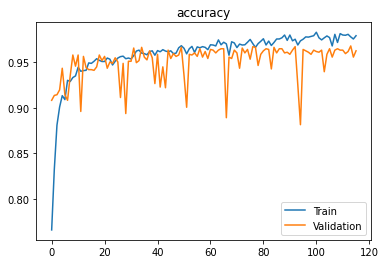

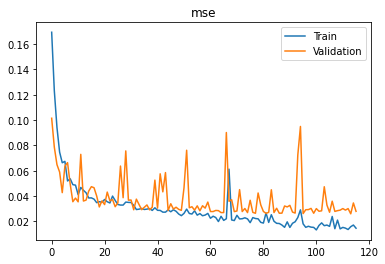

In [13]:
display(model.summary())

plot_results(history.history, ['accuracy', 'mse'])

### Create balanced dataset

### Create model with resampled dataset

### Add Regularization

Epoch 1/500
123/123 [==============================] - 2s 12ms/step - loss: 3.8131 - accuracy: 0.7310 - mse: 0.2039 - val_loss: 3.8857 - val_accuracy: 0.4625 - val_mse: 0.2883
Epoch 2/500
123/123 [==============================] - 1s 10ms/step - loss: 3.5074 - accuracy: 0.7944 - mse: 0.1359 - val_loss: 3.2914 - val_accuracy: 0.9190 - val_mse: 0.0726
Epoch 3/500
123/123 [==============================] - 1s 11ms/step - loss: 3.3309 - accuracy: 0.8812 - mse: 0.0936 - val_loss: 3.1998 - val_accuracy: 0.9075 - val_mse: 0.0685
Epoch 4/500
123/123 [==============================] - 1s 10ms/step - loss: 3.2024 - accuracy: 0.8957 - mse: 0.0775 - val_loss: 3.0965 - val_accuracy: 0.9213 - val_mse: 0.0608
Epoch 5/500
123/123 [==============================] - 1s 10ms/step - loss: 3.1571 - accuracy: 0.8808 - mse: 0.0858 - val_loss: 3.0750 - val_accuracy: 0.8968 - val_mse: 0.0753
Epoch 6/500
123/123 [==============================] - 1s 10ms/step - loss: 3.0350 - accuracy: 0.9104 - mse: 0.0672 - va

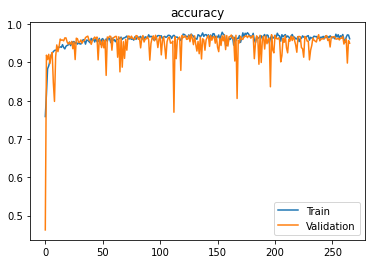

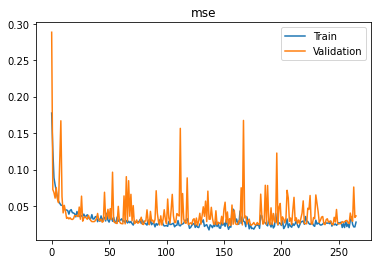

In [17]:
LAMBDA = 0.005
x, shape = make_flat(images)


model = Sequential()
model.add(Dense(256, activation='relu', input_shape = shape, kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='SGD', metrics=['accuracy', 'mse'], loss='categorical_crossentropy')

history = model.fit(x=x, y=labels, 
                    callbacks=callbacks, 
                    epochs=500, 
                    validation_split=0.25,
                    verbose=1)

plot_results(history.history, ['accuracy', 'mse'])

best_model = keras.models.load_model('best_model.h5')
best_model.summary()

### Add Dropout

In [ ]:
x, shape = make_flat(images)


LAMBDA = 0.005
DROPOUT = 0.3

model = Sequential()
model.add(Dense(256, activation='relu', input_shape = shape, kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(Dropout(DROPOUT))

model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(Dropout(DROPOUT))

model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(Dropout(DROPOUT))

model.add(Dense(2, activation='softmax'))

model.compile(optimizer='SGD', metrics=['accuracy', 'mse'], loss='categorical_crossentropy')

history = model.fit(x=x, y=labels, 
                    callbacks=callbacks, 
                    epochs=500,
                    validation_split=0.25)

plot_results(history.history, ['accuracy', 'mse'])

best_model = keras.models.load_model('best_model.h5')
best_model.summary()

### Remove the layer of 256 notes from previous model

Epoch 1/500
123/123 [==============================] - 2s 10ms/step - loss: 1.4763 - accuracy: 0.7057 - mse: 0.2132 - val_loss: 1.1766 - val_accuracy: 0.7439 - val_mse: 0.1442
Epoch 2/500
123/123 [==============================] - 1s 7ms/step - loss: 1.2698 - accuracy: 0.7243 - mse: 0.1786 - val_loss: 1.3719 - val_accuracy: 0.7416 - val_mse: 0.2241
Epoch 3/500
123/123 [==============================] - 1s 8ms/step - loss: 1.2293 - accuracy: 0.7472 - mse: 0.1708 - val_loss: 1.1366 - val_accuracy: 0.7416 - val_mse: 0.1364
Epoch 4/500
123/123 [==============================] - 1s 7ms/step - loss: 1.1856 - accuracy: 0.7314 - mse: 0.1617 - val_loss: 1.0281 - val_accuracy: 0.7416 - val_mse: 0.1143
Epoch 5/500
123/123 [==============================] - 1s 8ms/step - loss: 1.1288 - accuracy: 0.7309 - mse: 0.1490 - val_loss: 0.9874 - val_accuracy: 0.7416 - val_mse: 0.1058
Epoch 6/500
123/123 [==============================] - 1s 7ms/step - loss: 1.0969 - accuracy: 0.7455 - mse: 0.1429 - val_los

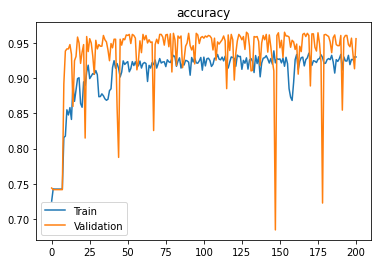

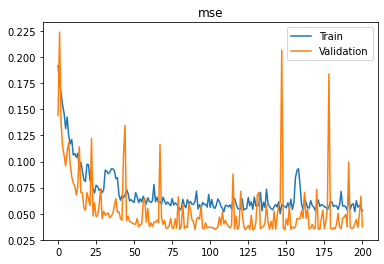

In [18]:
x, shape = make_flat(images)


LAMBDA = 0.005
DROPOUT = 0.3

model = Sequential()

model.add(Dense(64, activation='relu', input_shape = shape, kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(Dropout(DROPOUT))

model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(Dropout(DROPOUT))

model.add(Dense(2, activation='softmax'))

model.compile(optimizer='SGD', metrics=['accuracy', 'mse'], loss='categorical_crossentropy')

history = model.fit(x=x, y=labels, 
                    callbacks=callbacks, 
                    epochs=500,
                    validation_split=0.25)

plot_results(history.history, ['accuracy', 'mse'])

best_model = keras.models.load_model('best_model.h5')
best_model.summary()

### Use Conv2D() instead of Dense()

In [ ]:
LAMBDA = 0.005
DROPOUT = 0.3

model = Sequential()

model.add(Conv2D(64, activation='relu', kernel_size=5, input_shape=images.shape, padding='same'))
model.add(Conv2D(32, activation='relu', kernel_size=5, padding='same'))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam', metrics=['accuracy', 'mse'], loss='categorical_crossentropy')

history = model.fit(x=images, y=labels, 
                    callbacks=callbacks, 
                    epochs=500,
                    validation_split=0.25)

plot_results(history.history, ['accuracy', 'mse'])

best_model = keras.models.load_model('best_model.h5')
best_model.summary()